In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd
import A1_provider_prep
import A2_other
import A3_analysis
from calitp.sql import to_snakecase
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Save files to GCS
from calitp.storage import get_fs
fs = get_fs()

In [3]:
# Record start and end time
import datetime
from loguru import logger

In [4]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### Function to find a specific file based on a string.

In [5]:
def find_specific_files(phrase_to_find:str):
    """
    Grab a list of files that contain the 
    phrase inputted.
    """
    # Create a list of all the files in my folder
    all_files_in_folder = fs.ls(A1_provider_prep.GCS_FILE_PATH)
    
    # Grab only files with the string "Verizon_no_coverage_"
    my_files = [i for i in all_files_in_folder if phrase_to_find in i]
    
    # String to add to read the files
    my_string = "gs://"
    my_files = [my_string + i for i in my_files]
    
   
    return my_files

In [37]:
tmobile_dissolved = find_specific_files("tmobile_dissol")

### Function to clipped the sjoin result
* Created previously with `complete_difference_provider_district_level`.

In [6]:
def clip_sjoin_gdf(phrase_to_find:str, provider: str):
    """
    AT&T was spatially joined against each Caltrans
    District. However these sjoin gdfs are scraggly and
    include areas that don't belong to that district.
    Clip these sjoin files against the the original CT
    shapefile to clean up the edges. 
    """
    # Open original Caltrans districts shapefile
    # Get rid of A1_provider_prep once I export this
    ct_districts = A1_provider_prep.get_districts()
    
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    # Loop over every file
    # Put provider_files_list later.
    for file in provider_files_list:
        # Find which district each file contains. 
        # https://stackoverflow.com/questions/11339210/how-to-get-integer-values-from-a-string-in-python
        relevant_district = ''.join(i for i in file if i.isdigit())
        
        # Turn this into an integer
        relevant_district = int(relevant_district)
        
        # Filter out districts for the file's district
        relevant_district_gdf =  ct_districts[ct_districts.district == relevant_district]
        
        # Open file
        sjoin_file = gpd.read_parquet(file)
        
        # Clip the sjoin file against the original district shapefile
        clipped_gdf = sjoin_file.clip(relevant_district_gdf)
        
        # Save
        utils.geoparquet_gcs_export(clipped_gdf, A1_provider_prep.GCS_FILE_PATH, f"{provider}_clip_d{relevant_district}")
        
        print(f"Done for {relevant_district}") 

In [7]:
# clip_sjoin_gdf("Verizon_d", "verizon")

### Function to dissolve the clipped results.
* Change from clipped_gdf to clipped_dask
* Add times: https://github.com/cal-itp/data-analyses/blob/main/high_quality_transit_areas/A2_combine_stops.py

In [8]:
def dissolve_clipped_gdf(phrase_to_find:str, provider: str):
    """
    Input files created by `clip_sjoin_gdf` 
    and dissolve all the rows by district.
    """
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    # Loop over every file
    # Put provider_files_list later.
    for file in provider_files_list:
        
        start = datetime.datetime.now()
        
        # Open file
        clipped_dask = dg.read_parquet(file)
        
        # Grab the district
        relevant_district = ''.join(i for i in file if i.isdigit())
        
        # Turn this into an integer for the file name
        relevant_district = int(relevant_district)
        
        # Dissolve by district
        dissolved_dask = clipped_dask.dissolve("district")
        
        # Turn back to gdf
        dissolved_gdf = dissolved_dask.compute()
        
        # Save
        utils.geoparquet_gcs_export(dissolved_gdf, A1_provider_prep.GCS_FILE_PATH, f"{provider}_dissolve_d{relevant_district}")
        
        end = datetime.datetime.now()
        
        logger.info(f"execution time: {end-start}")
        print(f"Done for {relevant_district}") 

In [9]:
#2:35
# dissolve_clipped_gdf("verizon_clip_d", "verizon")

### Find Difference
* Take dissolved results and find the difference

In [38]:
tmobile_dissolved

['gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d1.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d10.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d11.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d12.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d2.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d3.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d4.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d5.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d6.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d7.parquet',
 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d8.parque

In [86]:
def find_difference_gdf(phrase_to_find:str, provider: str):
    """
    Input the files created by `dissolve_clipped_gdf` 
    and find the difference with the original Caltrans
    district. 
    """
    # Open original Caltrans districts shapefile
    # Get rid of A1_provider_prep once I export this
    ct_districts = A1_provider_prep.get_districts()
    
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    start = datetime.datetime.now()
    
    # Loop over every file
    for file in provider_files_list:
        
        relevant_district = ''.join(i for i in file if i.isdigit())
        
        relevant_district = int(relevant_district)
        
        # Filter out districts for the file's district
        relevant_district_gdf =  ct_districts[ct_districts.district == relevant_district]
        
        # Open file
        dissolved_file = gpd.read_parquet(file)
        
        # Clip the dissolved file against the original district shapefile
        no_coverage = relevant_district_gdf.difference(dissolved_file.geometry.iloc[0]).reset_index()
        
        try:
            # Some are geodataframes without column names
            no_coverage = no_coverage.rename(columns = {0: 'geometry'})
            utils.geoparquet_gcs_export(no_coverage, A1_provider_prep.GCS_FILE_PATH, f"{provider}_difference_d{relevant_district}")
        except:
            # Some become geoseries - turn them into a gdf
            # https://gis.stackexchange.com/questions/266098/how-to-convert-a-geoseries-to-a-geodataframe-with-geopandas
            no_coverage_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(no_coverage))
            utils.geoparquet_gcs_export(no_coverage_gdf, A1_provider_prep.GCS_FILE_PATH, f"{provider}_difference_d{relevant_district}")
        
        print(f"Done for {relevant_district}") 
            
    end = datetime.datetime.now()
    logger.info(f"execution time: {end-start}")
        
    return no_coverage

In [88]:
test = find_difference_gdf('verizon_dissolve_d','verizon')

Done for 1
Done for 10
Done for 11
Done for 12
Done for 2
Done for 3
Done for 4
Done for 5
Done for 6
Done for 7
Done for 8


2023-01-11 17:55:59.277 | INFO     | __main__:find_difference_gdf:45 - execution time: 0:35:11.671695


Done for 9


### Test Areas
* Scratch area for previewing files and making sure the results are right.

In [12]:
districts = A1_provider_prep.get_districts()

In [13]:
d9 =  districts[districts.district == 9]

In [14]:
d10 =  districts[districts.district == 10]

In [43]:
d1 =  districts[districts.district == 1]

In [39]:
# Dissolved T Mobile district 1 
tmobile_d1_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d1.parquet")

In [52]:
# Dissolved T Mobile district 10
tmobile_d10_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d10.parquet")

In [54]:
tmobile_d10_diss.shape

(1, 1)

In [59]:
# tmobile_d10_diss.plot()

In [55]:
difference_tmobile_d10 = d10.difference(tmobile_d10_diss.geometry.iloc[0]).reset_index()

In [60]:
type(difference_tmobile_d10)

geopandas.geodataframe.GeoDataFrame

In [44]:
difference_tmobile_d1 = d1.difference(tmobile_d1_diss.geometry.iloc[0]).reset_index()

In [47]:
type(difference_tmobile_d1)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

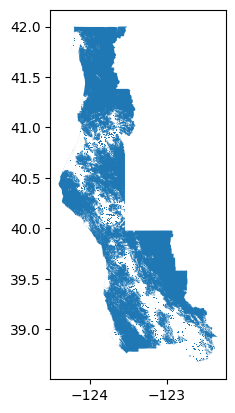

In [46]:
difference_tmobile_d1.plot()

In [45]:
gdf_d1 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(difference_tmobile_d1))

ValueError: The truth value of a GeoDataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<AxesSubplot:>

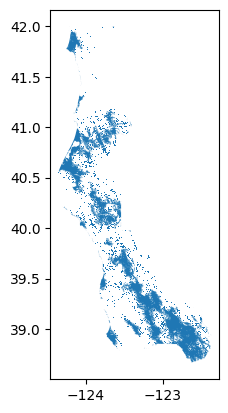

In [40]:
tmobile_d1_diss.plot()

In [15]:
# Dissolved T Mobile district 9 
tmobile_d9_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_dissolve_d9.parquet")

In [16]:
# Dissolved T Mobile district 9 
att_d10_diss = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/att_dissolve_d10.parquet")

In [17]:
att_d10_diss.shape, tmobile_d9_diss.shape

((1, 1), (1, 1))

In [20]:
# Now this is a geoseries
difference_tmobile_d9 = d9.difference(tmobile_d9_diss.geometry.iloc[0])

In [77]:
type(difference_tmobile_d9)

geopandas.geoseries.GeoSeries

In [26]:
# Turn this to a gdf
# https://gis.stackexchange.com/questions/266098/how-to-convert-a-geoseries-to-a-geodataframe-with-geopandas
test_geo = gpd.GeoDataFrame(geometry=gpd.GeoSeries(difference_tmobile_d9))

In [27]:
type(test_geo)

geopandas.geodataframe.GeoDataFrame

In [29]:
# Test saving
test_geo.to_parquet("./test.parquet")

In [82]:
test_geo.columns

Index(['geometry'], dtype='object')

In [30]:
# Make sure it opens alright
my_gdf =  gpd.read_parquet("./test.parquet")

In [31]:
type(my_gdf)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

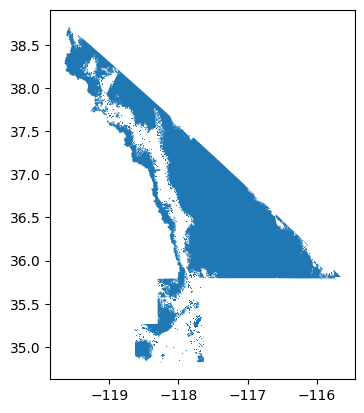

In [32]:
my_gdf.plot()

In [ ]:
# difference_att_d10 = d10.difference(att_d10_diss.geometry.iloc[0])

In [ ]:
difference_tmobile_d9.plot()

In [ ]:
difference_att_d10.plot()

In [ ]:
# tmobile_d9_diss.shape

In [ ]:
# tmobile_d9.plot()

In [ ]:
att_d2 = gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/att_clip_d2.parquet")

In [ ]:
# att_d2.plot()